# Analyse mechanochem - TABS

We assume that at $Wi \gg 1$, the growth of the longest segment in the chain is only a function of accumulated strain. Since the tension in that segment should scale with the strain rate, we conclude that the distribution of maximum tensions, hence the portion of broken chains, is only a function of $\varepsilon$ and $\dot\varepsilon$.


In [1]:
import numpy as np
from matsindy.feature_library import FeatureLibrary

from ipywidgets import interactive, fixed
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

## Datasets selection

In [2]:
Wi_max = 1000                       # Peak Weissenberg number in simulations
n_links = 1000                      # Number of segments in the Kramers chain
n_ensemble = 1000                     # Number of molecules to simulate

# Input folder
data_folder = 'outputs/Kramers'
                    
scenario = 'elongation_0_noBF_DP1.01'
with np.load(f"{data_folder}/{scenario}_Wi{Wi_max}_nlinks{n_links}_nmol{n_ensemble}.npz") as data:
    temp = dict(data)
    # Rename and normalise variables
    tau = 0.0142*n_links**2
    temp['A'] = temp.pop('A_average')/n_links**2
    temp['∇U'] = temp.pop('gradU')*tau
    temp['t'] = temp['t']/tau
    dgradU = np.zeros_like(temp['∇U'])
    dgradU[1:] = np.diff(temp['∇U'], axis=0)/np.diff(temp['t'])[:, None, None]
    temp['d∇U'] = dgradU
    temp['tr(Ad∇U)'] = np.trace(temp['A']@temp['d∇U'], axis1=1, axis2=2)
    # Add transposed variables
    temp['∇Uᵀ'] = np.transpose(temp['∇U'], axes=(0, 2, 1))
    # Principal strain rates
    temp['epsilon_dot'] = np.linalg.eigvalsh(0.5*(temp['∇U'] + temp['∇Uᵀ']))

    # Add features
    temp['tr(A)'] = np.trace(temp['A'], axis1=1, axis2=2)
    temp['tr(A∇U)'] = np.trace(temp['A']@temp['∇U'], axis1=1, axis2=2)
    # temp['tr(A∇U∇Uᵀ)'] = np.trace(temp['A']@temp['∇U']@temp['∇Uᵀ'], axis1=1, axis2=2)

    # Effective principal strain rate
    temp['w'] = temp['tr(A∇U)']/temp['tr(A)']

    # Estimates of the Henky strain, one using principal strain rates, the other using polymer extension
    h = np.zeros_like(temp['t'])
    h_prime = np.zeros_like(temp['t'])
    for i, dt in enumerate(np.diff(temp['t'])):
        h[i+1] = (np.amax(temp['epsilon_dot'][i]) + h[i]/dt)/(1./dt + 1./1.)
        h_prime[i+1] = (temp['tr(A∇U)'][i]/temp['tr(A)'][i] + h_prime[i]/dt)/(1./dt + 1./1.)
    temp['h'] = h
    temp['h_prime'] = h_prime

    # Effective square segment
    temp['L2'] = temp['g_max']/temp['epsilon_dot'][:,2]
    temp['M2'] = temp['g_12']/temp['epsilon_dot'][:,2]


# Save
data = temp

## Plot effective segments

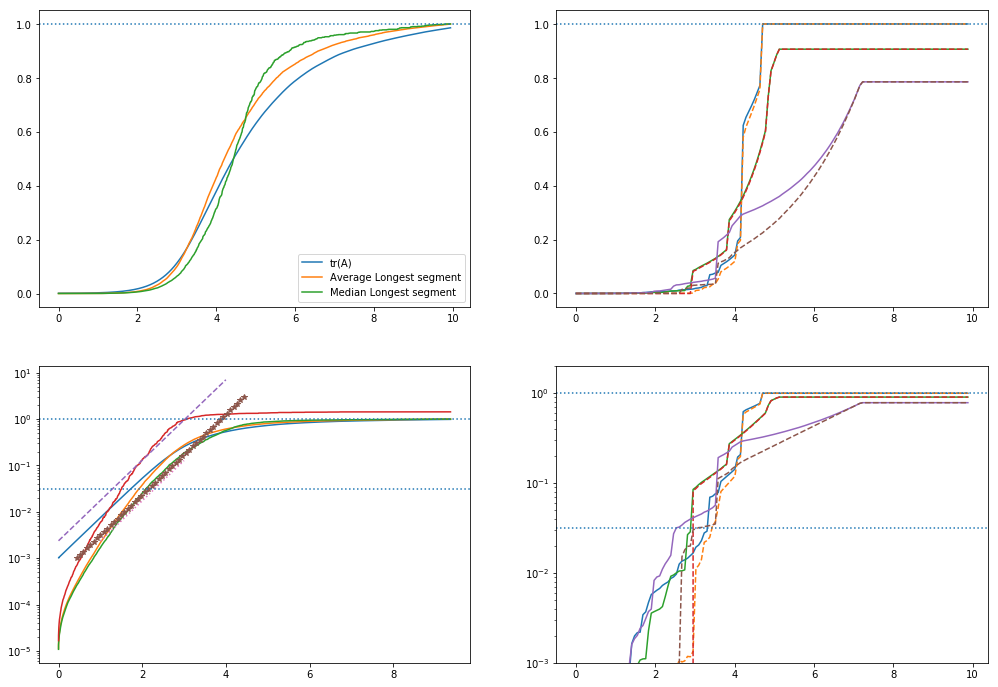

In [51]:
plt.rcParams['figure.figsize'] = [17, 12]
fig, ax = plt.subplots(ncols=2, nrows=2)
ax[0,0].plot(data['h'], data['tr(A)'], label='tr(A)')
ax[0,0].plot(data['h'], np.average(data['L2'], axis=0)*0.0142*8, label='Average Longest segment')
ax[0,0].plot(data['h'], np.median(data['L2'], axis=0)*0.0142*8, label='Median Longest segment')
ax[0,0].axhline(1, ls=':')
ax[0,0].legend()

for i in range(3):
    ax[0,1].plot(data['h'][::10], data['L2'][i,::10]*0.0142*8)
    ax[0,1].plot(data['h'][::10], data['M2'][i,::10]*0.0142*8, '--')
    
ax[0,1].axhline(1, ls=':')

ax[1,0].semilogy(data['h_prime'], data['tr(A)'])
ax[1,0].semilogy(data['h_prime'], np.average(data['L2'], axis=0)*0.0142*8)
ax[1,0].semilogy(data['h_prime'], np.median(data['L2'], axis=0)*0.0142*8)
ax[1,0].semilogy(data['h_prime'], np.percentile(data['L2'], 97, axis=0)*0.0142*8)
x = np.linspace(0,4)
ax[1,0].semilogy(x, np.exp(2*(x -np.log(n_links)*7/16)), '--')
ax[1,0].semilogy(x+np.log(n_links)/16, np.exp(2*(x -np.log(n_links)/2)), '*')
#ax[1,0].semilogy(x, np.exp(2.5*x -2.5/2*np.log(n_links)), '*')

x = np.linspace(1,3)
ax[1,0].semilogy(x, np.exp(2*(x-np.log(n_links)/12) -np.log(n_links)), ':')

ax[1,0].axhline(1, ls=':')
ax[1,0].axhline(1/n_links**0.5, ls=':')

for i in range(3):
    ax[1,1].semilogy(data['h'][::10], data['L2'][i,::10]*0.0142*8)
    ax[1,1].semilogy(data['h'][::10], data['M2'][i,::10]*0.0142*8, '--')
    
ax[1,1].set_ylim(1/n_links, 2)
ax[1,1].axhline(1, ls=':')
ax[1,1].axhline(1/n_links**0.5, ls=':')

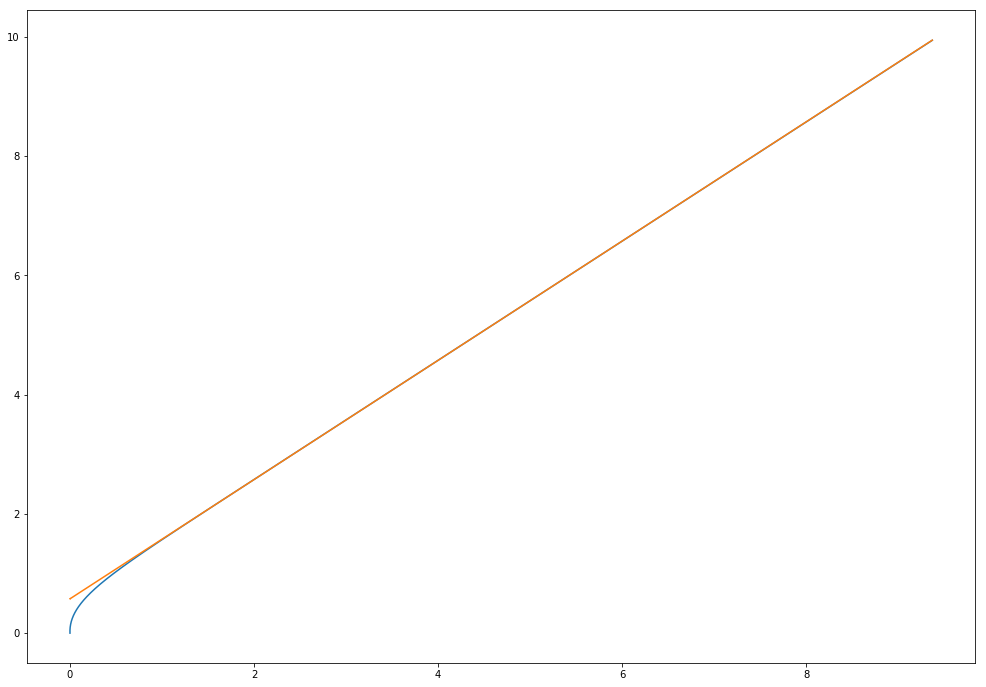

In [56]:
plt.plot(data['h_prime'], data['h'])
plt.plot(data['h_prime'], data['h_prime']+np.log(n_links)/12)

Onset of scission is likely to be with affine stretching, $e^{2h}=N$, therefore $h=\log(N)/2$. If scission occurs before full extension, 

### Effective segment for mechanophore activation

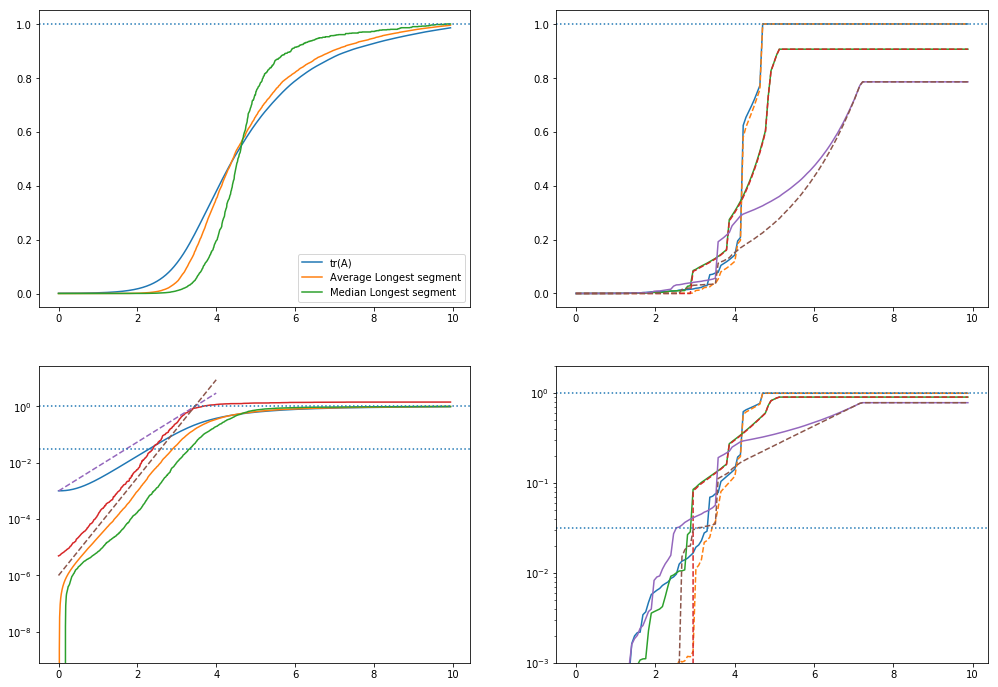

In [4]:
plt.rcParams['figure.figsize'] = [17, 12]
fig, ax = plt.subplots(ncols=2, nrows=2)
ax[0,0].plot(data['h'], data['tr(A)'], label='tr(A)')
ax[0,0].plot(data['h'], np.average(data['M2'], axis=0)*0.0142*8, label='Average Longest segment')
ax[0,0].plot(data['h'], np.median(data['M2'], axis=0)*0.0142*8, label='Median Longest segment')
ax[0,0].axhline(1, ls=':')
ax[0,0].legend()

for i in range(3):
    ax[0,1].plot(data['h'][::10], data['L2'][i,::10]*0.0142*8)
    ax[0,1].plot(data['h'][::10], data['M2'][i,::10]*0.0142*8, '--')
    
ax[0,1].axhline(1, ls=':')

ax[1,0].semilogy(data['h'], data['tr(A)'])
ax[1,0].semilogy(data['h'], np.average(data['M2'], axis=0)*0.0142*8)
ax[1,0].semilogy(data['h'], np.median(data['M2'], axis=0)*0.0142*8)
ax[1,0].semilogy(data['h'], np.percentile(data['M2'], 97, axis=0)*0.0142*8)
x = np.linspace(0,4)
ax[1,0].semilogy(x, np.exp(2*x -np.log(n_links)), '--')
ax[1,0].semilogy(x, np.exp(4*x -4./2*np.log(n_links)), '--')

ax[1,0].axhline(1, ls=':')
ax[1,0].axhline(1/n_links**0.5, ls=':')

for i in range(3):
    ax[1,1].semilogy(data['h'][::10], data['L2'][i,::10]*0.0142*8)
    ax[1,1].semilogy(data['h'][::10], data['M2'][i,::10]*0.0142*8, '--')
    
ax[1,1].set_ylim(1/n_links, 2)
ax[1,1].axhline(1, ls=':')
ax[1,1].axhline(1/n_links**0.5, ls=':')

## Simulate mechanophore activation and scission at constant strain rate

For an elongated chain, the maximum tension is at the centre and given by:
$$
g_\max = Wi\left(\frac{N^2}{8} + \frac{N}{2} \right)
$$
So a critical tension corresponds to a critical Weissenberg number
$$
Wi_c = \frac{g_c}{\frac{N^2}{8} + \frac{N}{2}}
$$
And there is a critical Wi for mechanophore activation: $Wi_m$.

In a TABS approach, we will define the molecular scission rate by:
$$
k = \frac{1}{\delta t}e^\frac{g-g_c}{N_K}
$$
where $N_K$ is of the order of the number of bonds in a Kuhn step. This comes from the way tension is normalized by $k_B T/b$ with $b$ the length og the Kuhn step.

880.2816901408451 880.2816901408451


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in add
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Ratio of rates')

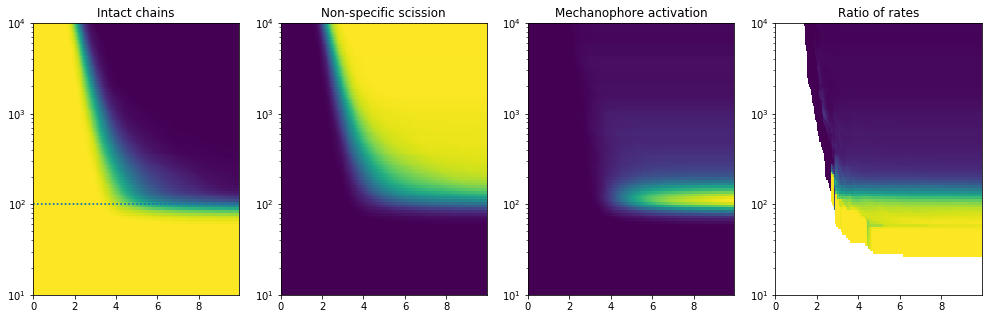

In [5]:
Wi_c = 100
Wi_m = 100
threshold = Wi_c/(8*0.0142)
mechanophore = Wi_m/(8*0.0142)
print(threshold, mechanophore)

# Number of bonds per Kuhn step
n_K = 10

# Strain step:
dh = data['h'][1] - data['h'][0]


cs = []
c_scissions = []
c_mechanophores = []
ratios = []

# Tensions are going to be rescaled with Wi
Wis = np.logspace(np.log10(Wi_m)-1,np.log10(Wi_c)+2,100)

for Wi in Wis:
    
    data['c'] = np.zeros_like(data['t'])
    data['c_scission'] = np.zeros_like(data['t'])
    data['c_mechanophore'] = np.zeros_like(data['t'])
    data['ratio'] = np.zeros_like(data['t'])

    scission_events = np.zeros_like(data['t'])
    mechanophore_events = np.zeros_like(data['t'])
    for tension_max, tension_centre in zip(Wi*data['L2'], Wi*data['M2']):
        # molecule by molecule
        k_scission = np.exp((tension_max-threshold)/n_K)
        k_mechanophore = np.exp((tension_centre-mechanophore)/n_K)
        
        # Ratio of scission over mech activation
        ratio = 1./(1+np.exp((tension_centre-mechanophore-tension_max+threshold)/n_K))
        #p_scission = 1-np.exp(-k_scission)
        
        # survival
        cmol = np.exp(-np.cumsum(k_scission+k_mechanophore))
        data['c'] += cmol/n_ensemble    
        
        # scission
        smol = np.zeros_like(cmol)
        smol[1:] = np.cumsum(-ratio[1:]*np.diff(cmol))
        data['c_scission'] += smol/n_ensemble 
        data['c_mechanophore'] += (1-cmol-smol)/n_ensemble 
        data['ratio'] += ratio*cmol/n_ensemble
                
    cs.append(data['c'])
    c_scissions.append(data['c_scission'])
    c_mechanophores.append(data['c_mechanophore'])
    ratios.append(data['ratio'])

cs = np.array(cs)
c_scissions = np.array(c_scissions)
c_mechanophores = np.array(c_mechanophores)
ratios = np.array(ratios)
#c_array[c_array==1] = np.nan
#c_array[c_array==0] = np.nan

plt.rcParams['figure.figsize'] = [17, 5]
fig, ax = plt.subplots(ncols=4)
ax[0].pcolormesh(data['h'], Wis, cs)
ax[0].axhline(Wi_c, ls=':')
ax[0].axhline(Wi_m, ls=':')
ax[0].set_yscale('log')
ax[0].set_title('Intact chains')

ax[1].pcolormesh(data['h'], Wis, c_scissions)
ax[1].set_yscale('log')
ax[1].set_title('Non-specific scission')

ax[2].pcolormesh(data['h'], Wis, c_mechanophores)
ax[2].set_yscale('log')
ax[2].set_title('Mechanophore activation')

ax[3].pcolormesh(data['h'], Wis, c_mechanophores/(c_mechanophores+c_scissions))
ax[3].set_yscale('log')
ax[3].set_title('Ratio of rates')


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


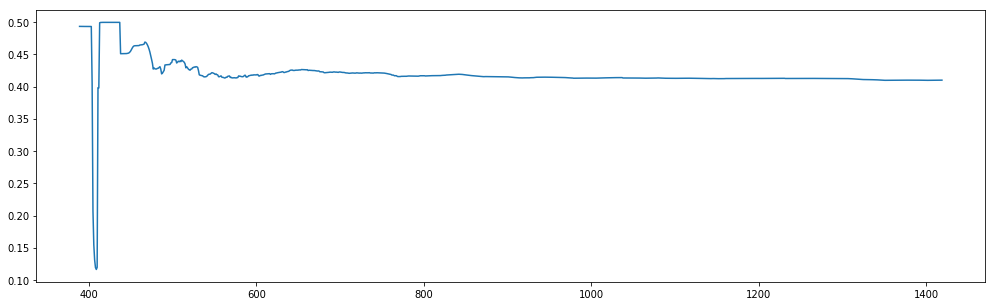

In [6]:
Wis[33]
plt.plot(c_mechanophores[33]/(c_mechanophores[33]+c_scissions[33]))

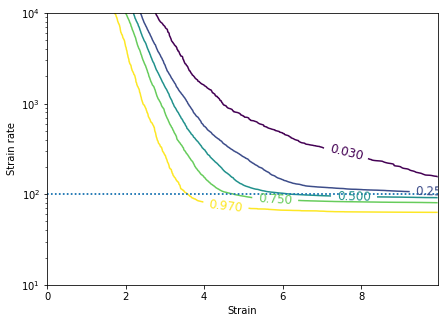

In [7]:
plt.rcParams['figure.figsize'] = [7, 5]
CS = plt.contour(data['h'], Wis, cs, [0.03, 0.25, 0.5, 0.75, 0.97])
plt.yscale('log')
#plt.xscale('log')

plt.clabel(CS, CS.levels, inline=True, fontsize=12)
plt.xlabel('Strain')
plt.ylabel('Strain rate')
plt.axhline(Wi_c, ls=':')
plt.axhline(Wi_m, ls=':')

## Fit of $k$

We need to observe that:
$$
\frac{dc}{dt} = \frac{1}{N_e}\sum \frac{dc_i}{dt} = -\frac{1}{N_e}\sum k_i c_i = -kc
$$

/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in true_divide
  
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


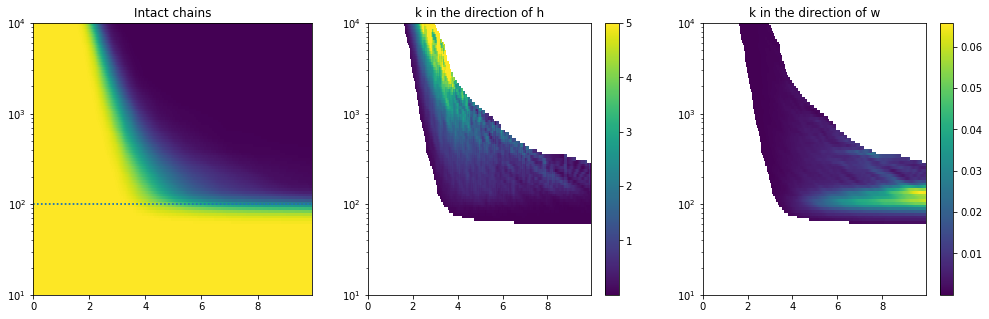

In [8]:
# further denoising
from scipy.signal import convolve2d
v = np.ones((2,20))
v = v/np.sum(v)
cs_d = convolve2d(cs, v, mode='same', boundary='symm')


k_h = np.zeros_like(cs)
k_h[:, 1:] = -np.diff(cs_d, axis=1)/np.diff(data['h'])/cs_d[:, 1:]
k_h[cs > 0.99] = np.nan
k_h[cs < 0.01] = np.nan

k_w = np.zeros_like(cs)
k_w[1:] = -np.diff(cs_d, axis=0)/np.diff(Wis)[:, None]/cs_d[1:]
k_w[cs > 0.99] = np.nan
k_w[cs < 0.01] = np.nan

plt.rcParams['figure.figsize'] = [17, 5]
fig, ax = plt.subplots(ncols=3)
ax[0].pcolormesh(data['h'], Wis, cs_d)
ax[0].axhline(Wi_c, ls=':')
ax[0].axhline(Wi_m, ls=':')
ax[0].set_yscale('log')
ax[0].set_title('Intact chains')

im1 = ax[1].pcolormesh(data['h'], Wis, k_h, vmax=5)
ax[1].set_yscale('log')
ax[1].set_title('k in the direction of h')
fig.colorbar(im1, ax=ax[1])

im2 = ax[2].pcolormesh(data['h'], Wis, k_w)
ax[2].set_yscale('log')
ax[2].set_title('k in the direction of w')
fig.colorbar(im2, ax=ax[2])

## View at various angles

### Lines of $c$

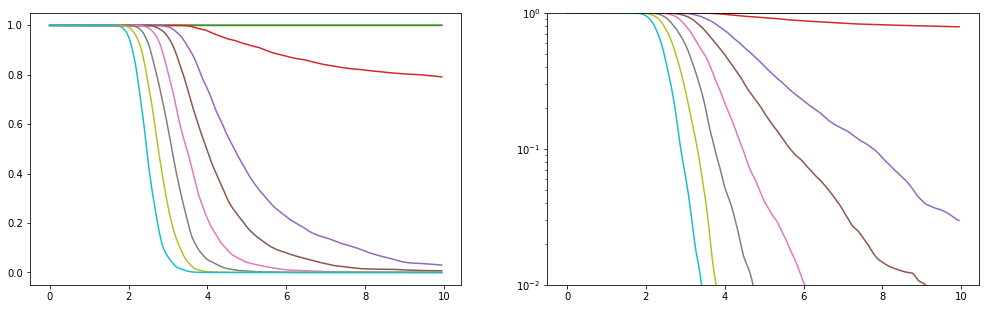

In [9]:
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = [17, 5]
fig, ax = plt.subplots(ncols=2)

for i, line in enumerate(cs_d):
    if i % 10 == 0:
        ax[0].plot(data['h'], line)
        ax[1].semilogy(data['h'], line)
        ax[1].set_ylim(1e-2, 1)

### Columns of $c$

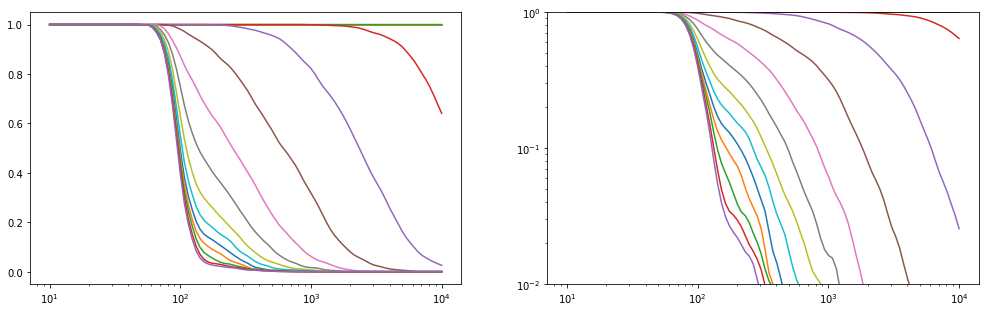

In [10]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, ax = plt.subplots(ncols=2)

for j in range(0, cs_d.shape[1], 100):
    ax[0].semilogx(Wis, cs_d[:, j])
    ax[1].loglog(Wis, cs_d[:, j])
    ax[1].set_ylim(1e-2, 1)

## Fit via $tr(A)$

The idea behind is this model would be more robust to the inclusion of hydrodynamic interactions, so long as we have a good model for $A$.

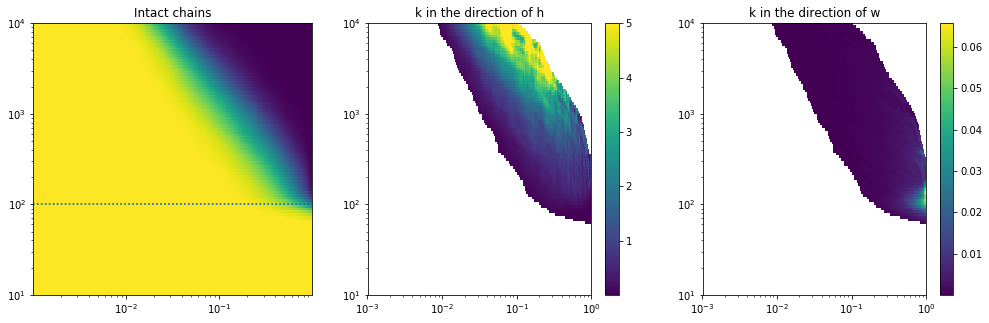

In [11]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, ax = plt.subplots(ncols=3)
ax[0].pcolormesh(data['tr(A)'], Wis, cs_d)
ax[0].axhline(Wi_c, ls=':')
ax[0].axhline(Wi_m, ls=':')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_title('Intact chains')

im1 = ax[1].pcolormesh(data['tr(A)'], Wis, k_h, vmax=5)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_title('k in the direction of h')
fig.colorbar(im1, ax=ax[1])

im2 = ax[2].pcolormesh(data['tr(A)'], Wis, k_w)
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_title('k in the direction of w')
fig.colorbar(im2, ax=ax[2])

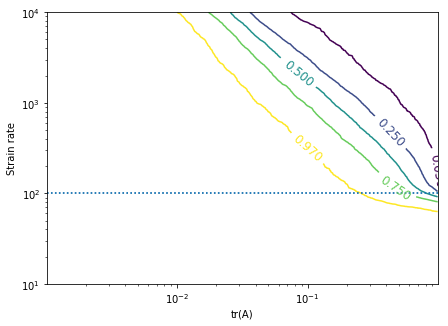

In [12]:
plt.rcParams['figure.figsize'] = [7, 5]
CS = plt.contour(data['tr(A)'], Wis, cs, [0.03, 0.25, 0.5, 0.75, 0.97])
plt.yscale('log')
plt.xscale('log')

plt.clabel(CS, CS.levels, inline=True, fontsize=12)
plt.xlabel('tr(A)')
plt.ylabel('Strain rate')
plt.axhline(Wi_c, ls=':')
plt.axhline(Wi_m, ls=':')

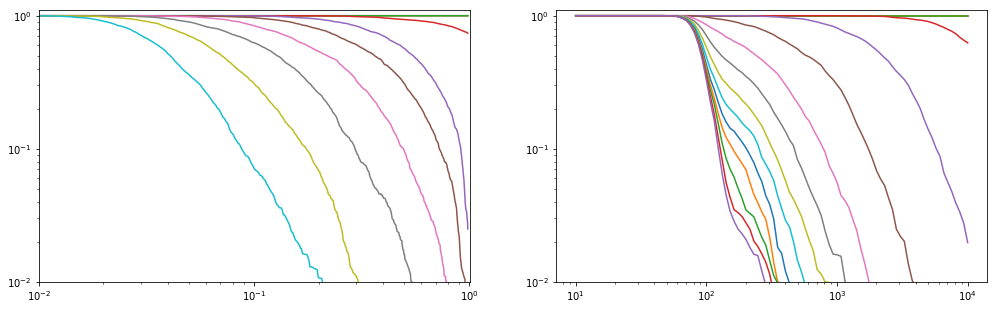

In [13]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, ax = plt.subplots(ncols=2)
for i in range(0,100,10):


    ax[0].loglog(data['tr(A)'], cs[i])
    ax[0].set_xlim(0.01, 1.01)
    ax[0].set_ylim(0.01, 1.1)
    
for j in range(0, cs.shape[1], 100):
    ax[1].loglog(Wis, cs[:, j])
    ax[1].set_ylim(0.01, 1.1)


/home/etienne/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


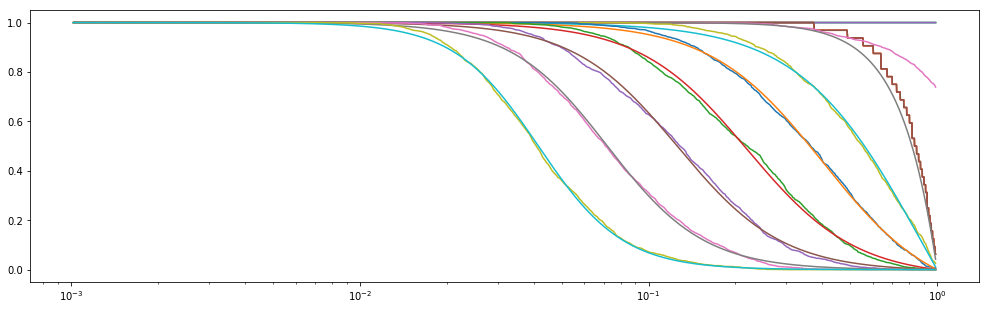

In [14]:
def c_model(x, x0, s):
    return (1 + np.exp(x0/s))/(1 + np.exp(np.log(x)/s-x0/s)) - np.exp(x0/s)


x0_table = []
s_table = []

for i, line in enumerate(cs):
    (x0, s), _ = curve_fit(c_model, data['tr(A)'], line, p0=(1,0.5))
    x0_table.append(x0)
    s_table.append(s)
    
    if i % 10 == 0:
        plt.semilogx(data['tr(A)'], cs[i])
        plt.semilogx(data['tr(A)'], c_model(data['tr(A)'], x0, s))

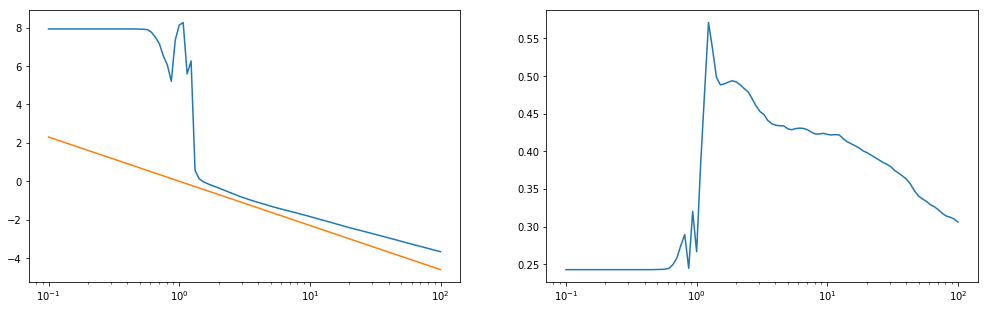

In [15]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, ax = plt.subplots(ncols=2)

ax[0].semilogx(Wis/Wi_c, x0_table)
ax[0].semilogx(Wis/Wi_c, -np.log(Wis/Wi_c))

ax[1].semilogx(Wis/Wi_c, s_table)

## Differential model

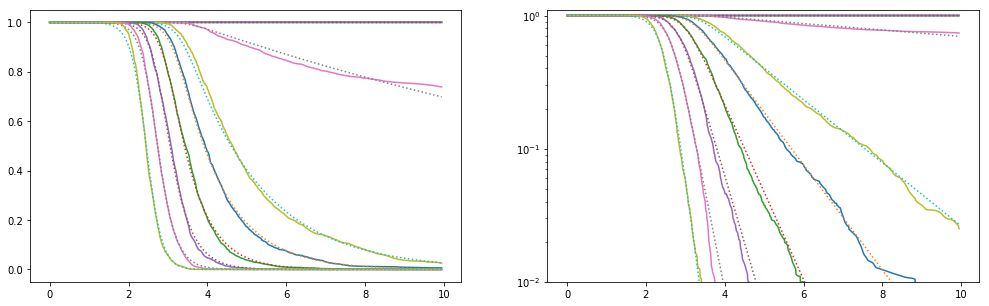

In [16]:
dh = data['h'][1] - data['h'][0]

plt.rcParams['figure.figsize'] = [17, 5]
fig, ax = plt.subplots(ncols=2)

def diff_model(x, alpha, beta, gamma):
    k = alpha/(1 + np.exp((0.5*np.log(n_links) - np.log(Wis[i]/Wi_c)/4 - x)/0.2))
    return np.exp(-np.cumsum(k)*dh)


alpha_table = []
beta_table = []
gamma_table = []

for i, line in enumerate(cs):
    (alpha, beta, gamma), _ = curve_fit(diff_model, data['h'], line)
    alpha_table.append(alpha)
    beta_table.append(beta)
    gamma_table.append(gamma)
    
    if i % 10 == 0:
        ax[0].plot(data['h'], cs[i])
        ax[0].plot(data['h'], diff_model(data['h'], alpha, beta, gamma), ':')
        
        ax[1].semilogy(data['h'], cs[i])
        ax[1].semilogy(data['h'], diff_model(data['h'], alpha, beta, gamma), ':')
        ax[1].set_ylim(0.01, 1.1)

In [17]:
gamma_table = np.array(gamma_table)
beta_table = np.array(beta_table)

(0, 1)

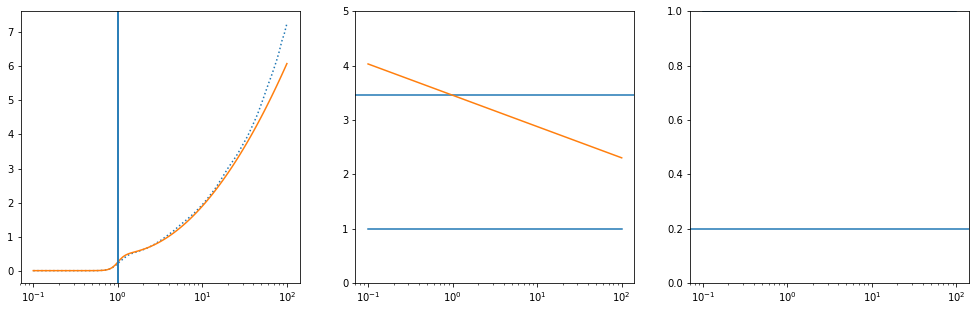

In [38]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, ax = plt.subplots(ncols=3)
ax[0].semilogx(Wis/Wi_m, alpha_table, ':')
alphas = 1/(1 + np.exp(-(np.log(Wis/Wi_m))/0.1))*(0.5+np.log(Wis/Wi_m)**2/3.8)
#alphas = 1/(1 + np.exp(-(np.log(Wis/Wi_m))/0.1))*(0.5*(Wis/Wi_m)**0.6)
ax[0].semilogx(Wis/Wi_m, alphas)
ax[0].axvline(Wi_c/Wi_m)
ax[0].axvline(1+(Wi_c/Wi_m-1)*5)

ax[1].semilogx(Wis/Wi_m, beta_table)
ax[1].axhline(np.log(n_links)/2)
ax[1].semilogx(Wis/Wi_m, 0.5*np.log(n_links) - np.log(Wis/Wi_m)/4)
ax[1].set_ylim(0,5)

ax[2].semilogx(Wis/Wi_m, gamma_table)
ax[2].axhline(0.2)
ax[2].set_ylim(0,1)

### Model $c$


[0.10155231 0.26423349 0.1697512  3.65925055]


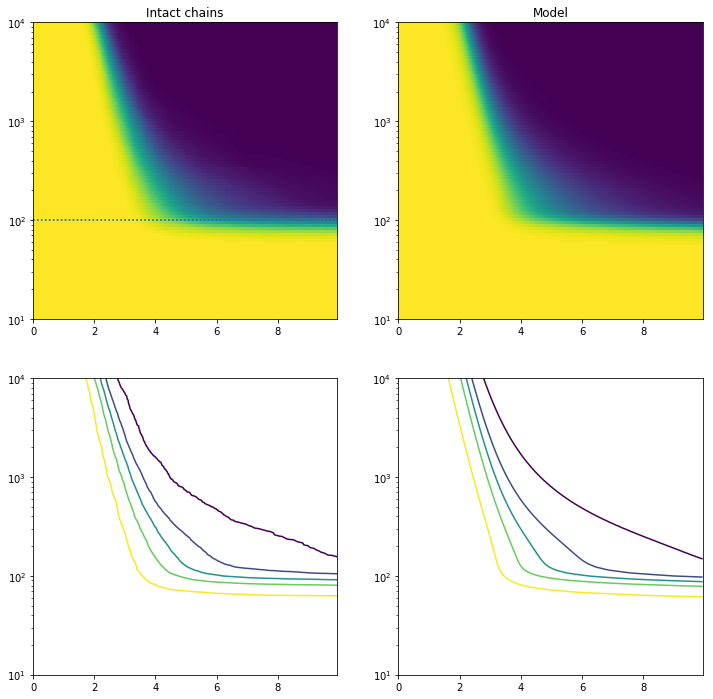

In [35]:
# Refit altogether

def build_model(params):
    c_model = np.ones_like(cs)
    
    for i, w in enumerate(Wis/Wi_m):
        #alpha = params[0]*np.log(1 + np.exp((np.log(w)/params[3])/params[0]))
        
        alpha = 1/(1 + np.exp(-(np.log(w))/params[0]))*(0.5 + np.log(w)**2/params[3])
        #alpha = 1/(1 + np.exp(-(np.log(w))/params[0]))*(0.5*w**0.6)
        
        
        beta = 0.5*np.log(n_links) - params[1]*np.log(w)
        gamma = params[2]
        #c_model[i] = np.exp(-alpha*gamma*np.log((1+np.exp(-beta/gamma+data['h']/gamma))/(1+np.exp(-beta/gamma))))
        
        c_model[i] = np.exp(-alpha*gamma*np.log((1+np.exp(-beta/gamma+data['h']/gamma))))
        
    return c_model


def cost(params):
    return np.sum((cs-build_model(params))**2)


from scipy.optimize import minimize
                                    
res = minimize(cost, [0.15, 0.25, 0.2, 5])

print(res.x)

c_model = build_model(res.x)

plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots(ncols=2, nrows=2)
ax[0, 0].pcolormesh(data['h'], Wis, cs)
ax[0, 0].axhline(Wi_c, ls=':')
ax[0, 0].axhline(Wi_m, ls=':')
ax[0, 0].set_yscale('log')
ax[0, 0].set_title('Intact chains')

ax[0, 1].pcolormesh(data['h'], Wis, c_model)
ax[0, 1].set_yscale('log')
ax[0, 1].set_title('Model')

ax[1, 0].contour(data['h'], Wis, cs, [0.03, 0.25, 0.5, 0.75, 0.97])
ax[1, 0].set_yscale('log')
#ax[1, 0].set_xscale('log')

ax[1, 1].contour(data['h'], Wis, c_model, [0.03, 0.25, 0.5, 0.75, 0.97])
ax[1, 1].set_yscale('log')
#ax[1, 1].set_xscale('log')

## Scission versus activation

In [20]:
intact_chains = np.outer(Wis, data['h'])
# Differential tables
dw_to_scission = np.zeros_like(intact_chains)
dw_to_mechanophore = np.zeros_like(intact_chains)
dh_to_scission = np.zeros_like(intact_chains)
dh_to_mechanophore = np.zeros_like(intact_chains)

dw_efficiency = np.zeros_like(intact_chains)
dh_efficiency = np.zeros_like(intact_chains)

for i, Wi in enumerate(Wis):
    for j, h in enumerate(data['h']):
        # Distributions
        tension_maxs, tension_centres = Wi*data['L2'][:,j], Wi*data['M2'][:,j]
        # Conditional distribution, to find intact chains
        T = (tension_maxs < threshold) * (tension_centres < mechanophore)
        intact_chains[i, j] = np.sum(T)/n_ensemble
        
        # From this point, investigate what happens if we increase strain rate:
        i_step = 3
        if i < len(Wis)-i_step:
            # Select only intact chains only:
            T_dw = tension_centres[T]/Wi*Wis[i+i_step] > mechanophore
            dw_to_mechanophore[i, j] = np.sum(T_dw)/n_ensemble

            T_dw = (tension_maxs[T]/Wi*Wis[i+i_step] > threshold) * (tension_centres[T]/Wi*Wis[i+i_step] < mechanophore)
            dw_to_scission[i, j] = np.sum(T_dw)/n_ensemble
            
            dw_efficiency[i, j] = dw_to_mechanophore[i, j]/(dw_to_mechanophore[i, j] + dw_to_scission[i, j])
        
        # Or if we increase strain:
        j_step = 20
        if j < len(data['h']) - j_step:
            # Or we increase h
            tension_maxs2, tension_centres2 = Wi*data['L2'][:,j+j_step], Wi*data['M2'][:,j+j_step]
            T_dh = tension_centres2[T] > mechanophore
            dh_to_mechanophore[i, j] = np.sum(T_dh)/n_ensemble

            T_dh = (tension_maxs2[T] > threshold) * (tension_centres2[T] < mechanophore)
            dh_to_scission[i, j] = np.sum(T_dh)/n_ensemble
            
            dh_efficiency[i, j] = dh_to_mechanophore[i, j]/(dh_to_mechanophore[i, j] + dh_to_scission[i, j])

/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 1.0, 'Efficiency with strain')

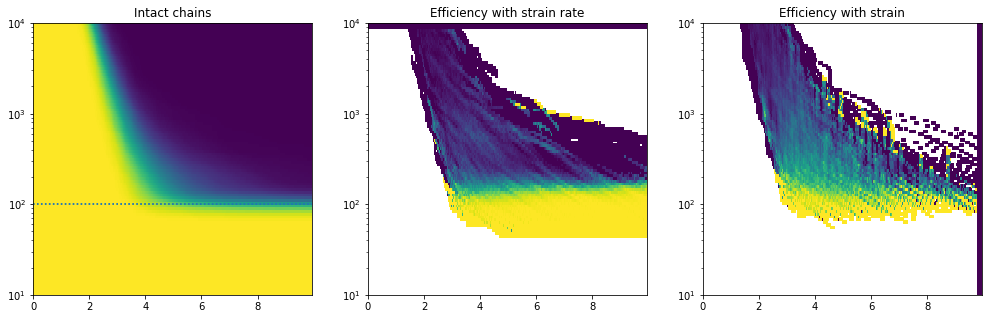

In [21]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, ax = plt.subplots(ncols=3, nrows=1)
ax[0].pcolormesh(data['h'], Wis, intact_chains)
ax[0].axhline(Wi_c, ls=':')
ax[0].axhline(Wi_m, ls=':')
ax[0].set_yscale('log')
ax[0].set_title('Intact chains')

ax[1].pcolormesh(data['h'], Wis, dw_efficiency)
ax[1].set_yscale('log')
ax[1].set_title('Efficiency with strain rate')

ax[2].pcolormesh(data['h'], Wis, dh_efficiency)
ax[2].set_yscale('log')
ax[2].set_title('Efficiency with strain')

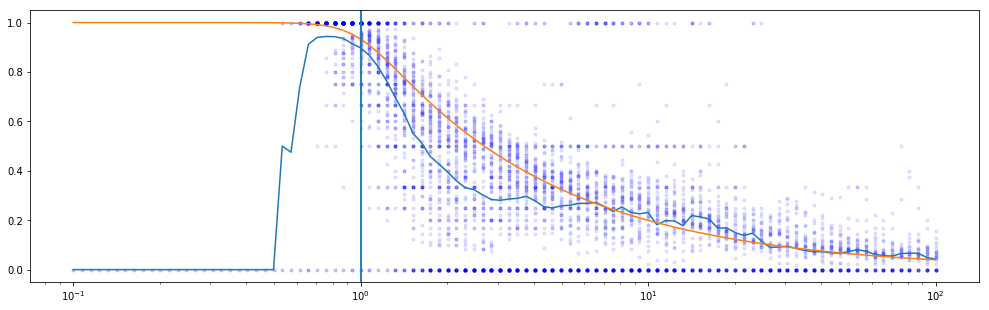

In [22]:
for j in range(0,len(data['h']), 10):
    plt.semilogx(Wis/Wi_m, dh_efficiency[:,j], 'b.', alpha=0.1)
plt.semilogx(Wis/Wi_m, np.nanmean(dh_efficiency, axis=1), '-')
    
gamma = 0.1
Wi_star = 4*Wi_c- 3*Wi_m
y = 1./(1 + (Wis/Wi_star)**(0.7/gamma))**gamma
plt.semilogx(Wis/Wi_m, y)
plt.axvline(Wi_c/Wi_m)
plt.axvline(Wi_star/Wi_m)

/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


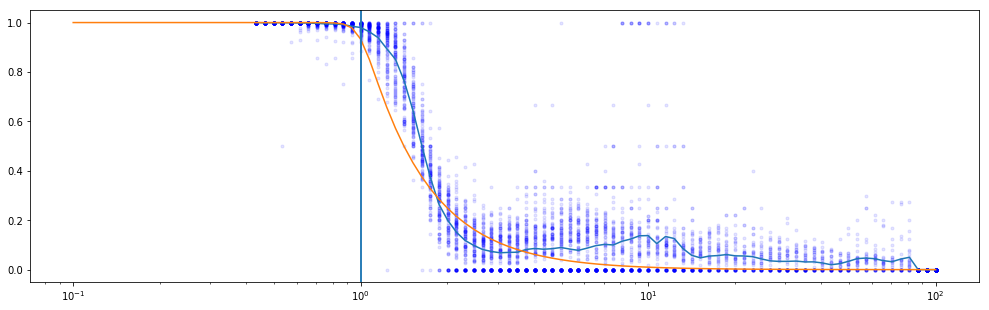

In [23]:
for j in range(0,len(data['h']), 10):
    plt.semilogx(Wis/Wi_m, dw_efficiency[:,j], 'b.', alpha=0.1)
plt.semilogx(Wis/Wi_m, np.nanmean(dw_efficiency, axis=1), '-')

gamma = 0.1
Wi_star = 4*Wi_c- 3*Wi_m
y = 1./(1 + (Wis/Wi_star)**(2/gamma))**gamma
plt.semilogx(Wis/Wi_m, y)    
plt.axvline(Wi_c/Wi_m)
plt.axvline(Wi_star/Wi_m)

### Average model

/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


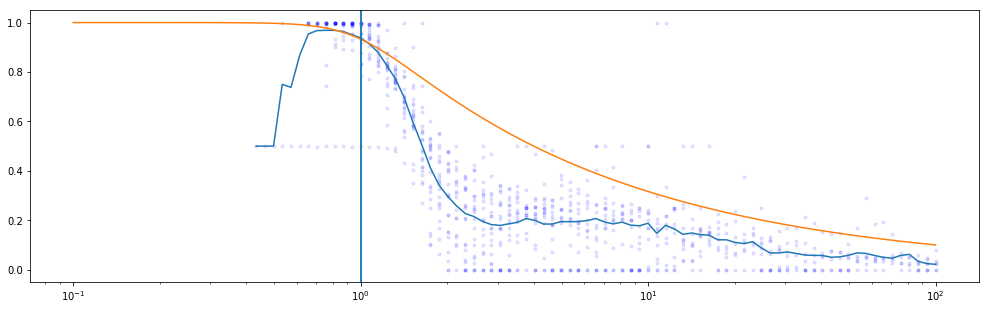

In [24]:
av_efficiency = 0.5*(dh_efficiency + dw_efficiency)

for j in range(0,len(data['h']), 50):
    plt.semilogx(Wis/Wi_m, av_efficiency[:,j], 'b.', alpha=0.1)
plt.semilogx(Wis/Wi_m, np.nanmean(av_efficiency, axis=1), '-')
    
gamma = 0.1
Wi_star = 3*Wi_c- 2*Wi_m
y = 1./(1 + (Wis/Wi_star)**(0.5/gamma))**gamma
plt.semilogx(Wis/Wi_m, y)
plt.axvline(Wi_c/Wi_m)
plt.axvline(Wi_star/Wi_m)

## Model of activation vs scission

To test the ratio model, we use trajectories of some form 

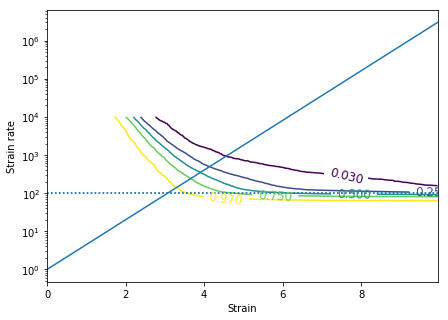

In [25]:
xi = 1.5
Wi_syn = np.exp(xi*data['h'])

plt.rcParams['figure.figsize'] = [7, 5]
CS = plt.contour(data['h'], Wis, cs, [0.03, 0.25, 0.5, 0.75, 0.97])
plt.yscale('log')
#plt.xscale('log')

plt.clabel(CS, CS.levels, inline=True, fontsize=12)
plt.xlabel('Strain')
plt.ylabel('Strain rate')
plt.axhline(Wi_c, ls=':')
plt.axhline(Wi_m, ls=':')

plt.plot(data['h'], Wi_syn)

In [26]:
# Calculating outcome for this trajectory:

scission_events = np.zeros_like(data['t'])
mechanophore_events = np.zeros_like(data['t'])
for L2, M2 in zip(data['L2'], data['M2']):
    for i, (g_max, g_12) in enumerate(zip(Wi_syn*L2, Wi_syn*M2)):

        if g_max > threshold and g_12 < mechanophore:
            # Non-specific scission
            scission_events[i] += 1
            break
        if g_12 > mechanophore:
            # mechanophore activation
            mechanophore_events[i] += 1
            break

syn_scission = np.cumsum(scission_events)/n_ensemble
syn_mechanophore = np.cumsum(mechanophore_events)/n_ensemble
syn_c = 1. - (syn_scission + syn_mechanophore)

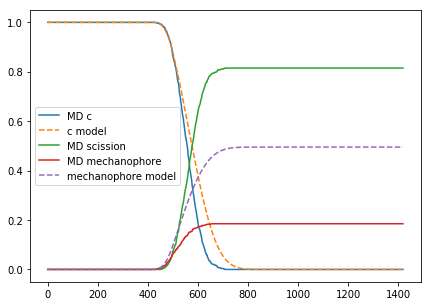

In [27]:
w = Wi_syn/Wi_m
alpha = (0.5 + np.log(w)**2/10.8)/(1 + np.exp(-(np.log(w))/0.1))
beta = 0.5*np.log(n_links) - 0.22*np.log(w)
gamma = 0.14

minus_log_c = alpha*gamma*np.log((1+np.exp(-beta/gamma+data['h']/gamma)))

#syn_c_model = np.exp(-minus_log_c)

#d_w = xi*w

d_alpha = (xi*2*np.log(w)/7.6)/(1 + np.exp(-(np.log(w))/0.1))
d_alpha += (0.5 + np.log(w)**2/7.6)/(1 + np.exp(-(np.log(w))/0.1))**2*(np.exp(-(np.log(w))/0.1)*xi/0.1)

k_h = d_alpha*gamma*np.log((1+np.exp(-beta/gamma+data['h']/gamma)))
k_h += alpha/(1+np.exp(-beta/gamma+data['h']/gamma))*(1+xi*0.22)*np.exp(-beta/gamma+data['h']/gamma)

gamma = 0.1
Wi_star = 3*Wi_c- 2*Wi_m
efficiency = 1./(1 + (Wi_syn/Wi_star)**(0.5/gamma))**gamma

dh = data['h'][1] - data['h'][0]
syn_c_model = np.exp(-np.cumsum(k_h)*dh)
d_c = np.diff(syn_c_model)
syn_mechanophore_model = np.zeros_like(data['h'])
syn_mechanophore_model[1:] = -np.cumsum(efficiency[1:]*d_c)

plt.plot(syn_c, label='MD c')
plt.plot(syn_c_model, '--', label='c model')
plt.plot(syn_scission, label='MD scission')
plt.plot(syn_mechanophore, label='MD mechanophore')
plt.plot(syn_mechanophore_model, '--', label='mechanophore model')
plt.legend()

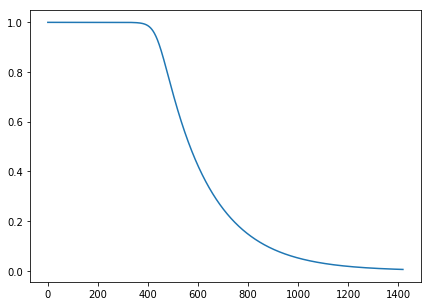

In [28]:
plt.plot(efficiency)

In [29]:
np.sqrt(4e-3/0.01)

0.6324555320336759

In [30]:
np.exp(100)

2.6881171418161356e+43

In [31]:
np.log(10)/4/0.2

2.878231366242557

In [32]:
1/0.23

4.3478260869565215